In [60]:
# Basic packages always been used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

# Data scaling
from sklearn.preprocessing import MinMaxScaler

# Function for spilting training & testing data set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


# Tensorflow sequential models
from tensorflow import keras
from keras import backend as clear
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import RMSprop

# Functions for evaluation
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE,RMSE
from sklearn.metrics import mean_absolute_percentage_error #MAPE
from tensorflow.keras.layers import GRU
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

In [61]:
#忽略警告訊息
warnings.filterwarnings('ignore')

# Note: Some metrics need to be defined manually

In [2]:
# Symmetric Mean Absolute Percentage Error (SMAPE)
def SMAPE_calulate(y_true, y_pred):
    n = len(y_true)
    SMAPE=(100 / n) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))
    return SMAPE

# Relative Absolute Error (RAE)
def RAE_calculate(y_true, y_pred):
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    return RAE

# Mean Relative Absolute Error (MRAE)
def MRAE_calculate(y_true, y_pred):
    n=len(y_true)
    abs_errors = np.abs(y_true - y_pred)
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    RAE=np.sum(abs_errors/denominator)
    MRAE=RAE/n
    return MRAE

# Median Relative Absolute Error (MdRAE) comparing with benchmark
# Note: By default, the bench value is the mean of actual value
def MdRAE_calculate(y_true, y_pred, bench=None):
    if bench==None:
        bench=np.mean(y_true)
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE,bench
    else:
        MdRAE=np.median(np.abs(y_true - y_pred)/np.abs(y_true - bench))
        return MdRAE

# Relative Squared Error (RSE) & Root Relative Squared Error (RRSE)
def RSE_calculate(y_true, y_pred, Root=False):
    mse = np.mean((y_true - y_pred)**2)
    denominator = np.var(y_true)
    RSE=mse/denominator

    if Root==True:
        return np.sqrt(RSE)
    else:
        return RSE

In [3]:
data = pd.read_csv("C:/Users/king0/OneDrive/桌面/DL DATA/NVDA15-23.csv")
data

,Date,Y,Lag_1,Lag_2,Lag_3
0,2015/1/2,5.032500,5.012500,5.092500,5.140000
1,2015/1/5,4.947500,5.032500,5.012500,5.092500
2,2015/1/6,4.797500,4.947500,5.032500,5.012500
3,2015/1/7,4.785000,4.797500,4.947500,5.032500
4,2015/1/8,4.965000,4.785000,4.797500,4.947500
...,...,...,...,...,...
2109,2023/5/19,312.640015,316.779999,301.779999,292.130005
2110,2023/5/22,311.760010,312.640015,316.779999,301.779999
2111,2023/5/23,306.880005,311.760010,312.640015,316.779999
2112,2023/5/24,305.380005,306.880005,311.760010,312.640015


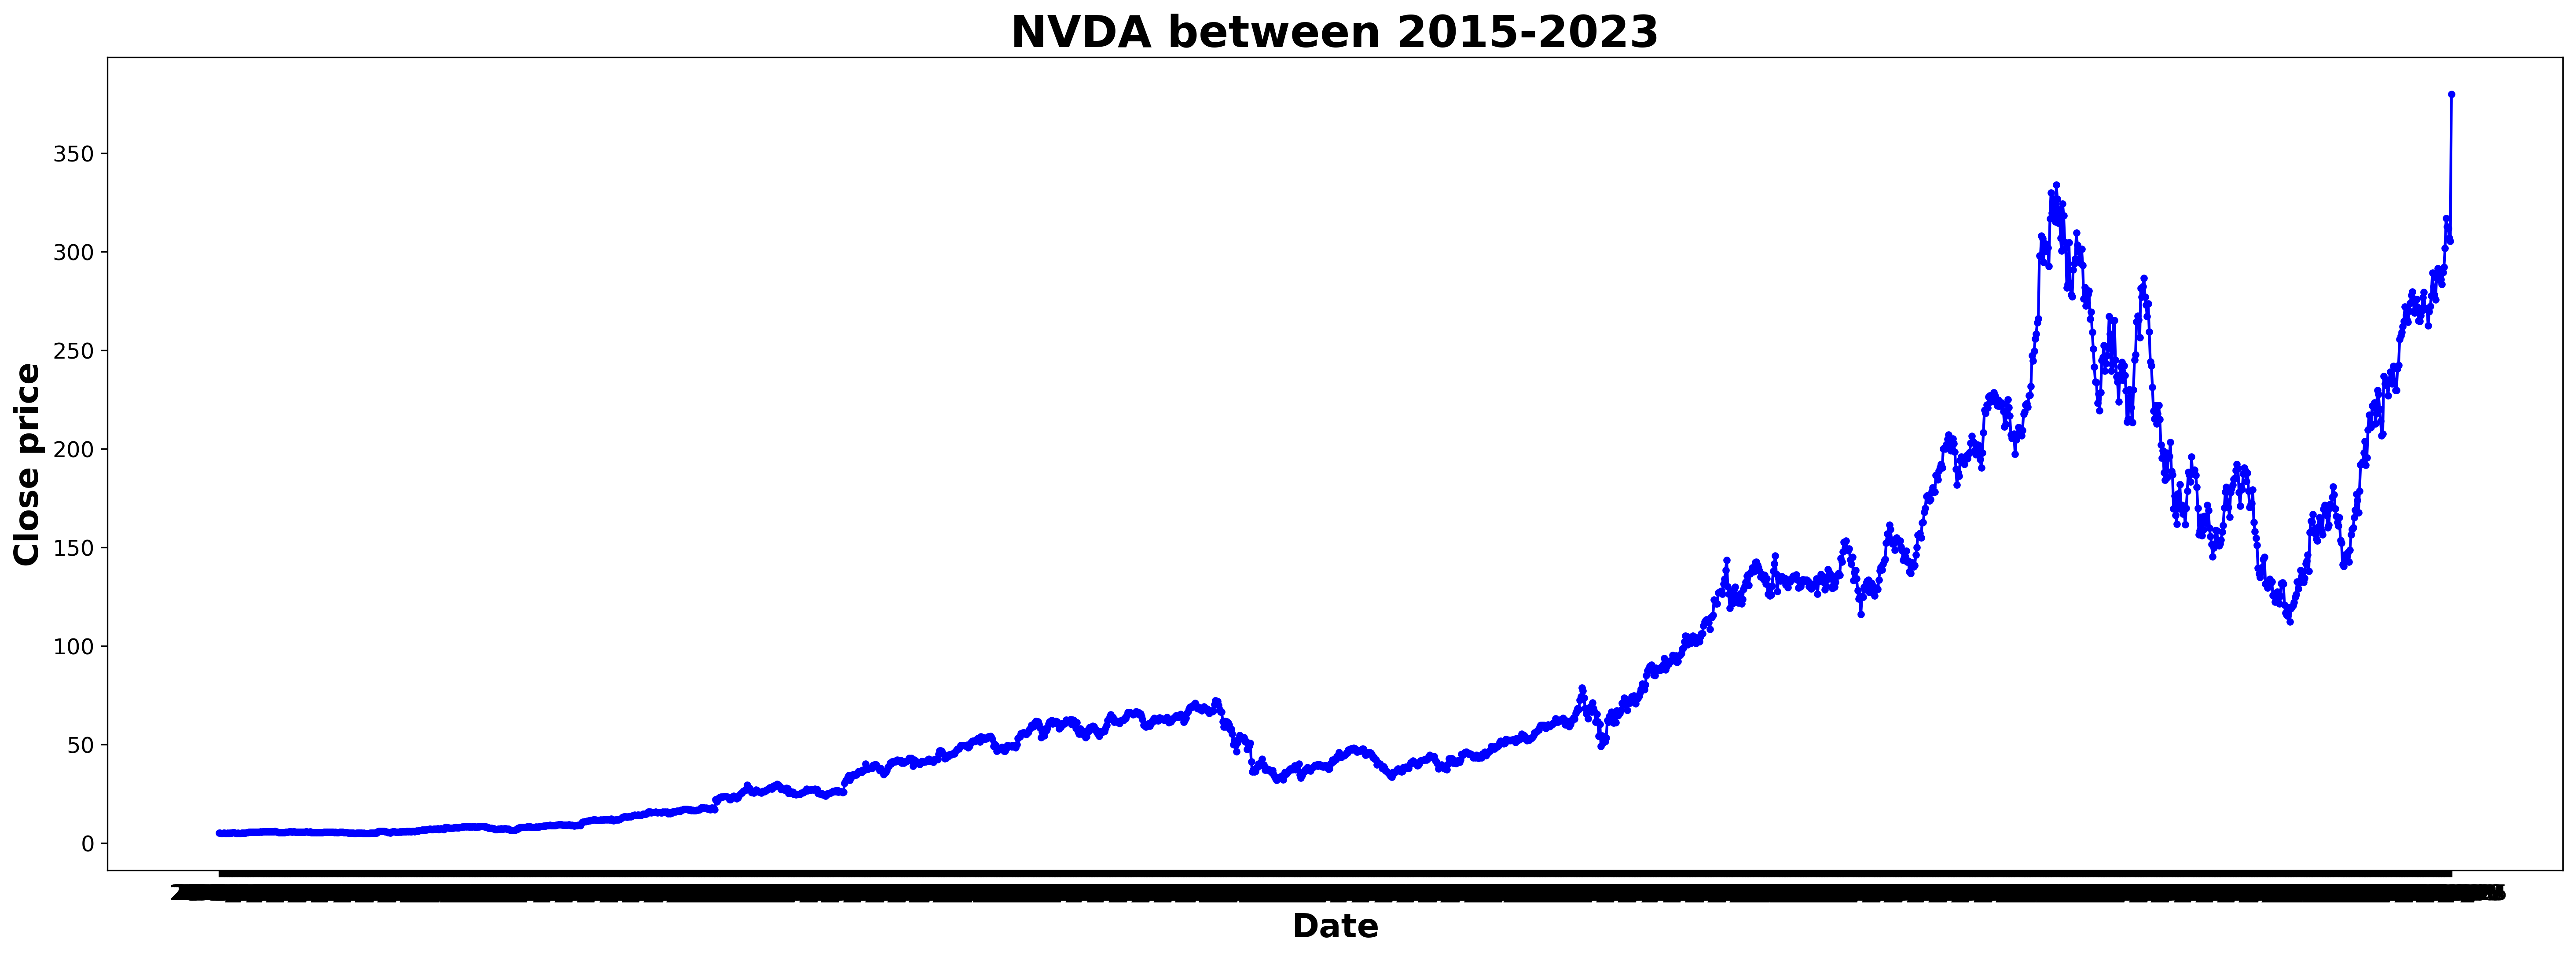

In [4]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('NVDA between 2015-2023',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Close price',fontsize=18,weight='bold')

# Actual by predicted plot
plt.plot(data['Date'],data['Y'],marker='.',color='blue')

# Set the axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [5]:
x=data.drop(['Date' , 'Y'],axis=1).copy()
x.head()

,Lag_1,Lag_2,Lag_3
0,5.0125,5.0925,5.1400
1,5.0325,5.0125,5.0925
2,4.9475,5.0325,5.0125
3,4.7975,4.9475,5.0325
4,4.7850,4.7975,4.9475


In [6]:
y=data['Y'].copy()
y.head()

0    5.0325
1    4.9475
2    4.7975
3    4.7850
4    4.9650
Name: Y, dtype: float64

# Rolling window

In [7]:
#Rolling window 切資料
x_train1 = x[0:422]
x_validation1 = x[422:844]
y_train1 = y[0:422]
y_validation1 = y[422:844]

x_train2 = x[422:844]
x_validation2 = x[844:1266]
y_train2 = y[422:844]
y_validation2 = y[844:1266]

x_train3 = x[844:1266]
x_validation3 = x[1266:1688]
y_train3 = y[844:1266]
y_validation3 = y[1266:1688]

# 第一組正規化

In [8]:
#做正規化
MMscaler=MinMaxScaler(feature_range=(0, 1))
normalize_df=MMscaler.fit_transform(x_train1)
new_x_train1=pd.DataFrame(data=normalize_df)
new_x_train1.columns=x.columns
print(new_x_train1.head())

#做正規化
MMscaler=MinMaxScaler(feature_range=(0, 1))
normalize_df=MMscaler.fit_transform(x_validation1)
new_x_validation1=pd.DataFrame(data=normalize_df)
new_x_validation1.columns=x.columns
print(new_x_validation1.head())

      Lag_1     Lag_2     Lag_3
0  0.020677  0.028018  0.032346
1  0.022495  0.020729  0.028018
2  0.014769  0.022551  0.020729
3  0.001136  0.014806  0.022551
4  0.000000  0.001139  0.014806
      Lag_1     Lag_2     Lag_3
0  0.015762  0.019009  0.009531
1  0.018852  0.015762  0.019009
2  0.013982  0.018852  0.015762
3  0.016339  0.013982  0.018852
4  0.000000  0.016339  0.013982


# 第二組正規化

In [9]:
#做正規化
MMscaler=MinMaxScaler(feature_range=(0, 1))
normalize_df=MMscaler.fit_transform(x_train2)
new_x_train2=pd.DataFrame(data=normalize_df)
new_x_train2.columns=x.columns
print(new_x_train2.head())

#做正規化
MMscaler=MinMaxScaler(feature_range=(0, 1))
normalize_df=MMscaler.fit_transform(x_validation2)
new_x_validation2=pd.DataFrame(data=normalize_df)
new_x_validation2.columns=x.columns
print(new_x_validation2.head())

      Lag_1     Lag_2     Lag_3
0  0.015762  0.019009  0.009531
1  0.018852  0.015762  0.019009
2  0.013982  0.018852  0.015762
3  0.016339  0.013982  0.018852
4  0.000000  0.016339  0.013982
      Lag_1     Lag_2     Lag_3
0  0.793074  0.759921  0.749322
1  0.819879  0.793074  0.759921
2  0.785371  0.819879  0.793074
3  0.790486  0.785371  0.819879
4  0.730096  0.790486  0.785371


# 第三組正規化

In [10]:
#做正規化
MMscaler=MinMaxScaler(feature_range=(0, 1))
normalize_df=MMscaler.fit_transform(x_train3)
new_x_train3=pd.DataFrame(data=normalize_df)
new_x_train3.columns=x.columns
print(new_x_train3.head())

#做正規化
MMscaler=MinMaxScaler(feature_range=(0, 1))
normalize_df=MMscaler.fit_transform(x_validation3)
new_x_validation3=pd.DataFrame(data=normalize_df)
new_x_validation3.columns=x.columns
print(new_x_validation3.head())

      Lag_1     Lag_2     Lag_3
0  0.793074  0.759921  0.749322
1  0.819879  0.793074  0.759921
2  0.785371  0.819879  0.793074
3  0.790486  0.785371  0.819879
4  0.730096  0.790486  0.785371
      Lag_1     Lag_2     Lag_3
0  0.077483  0.066804  0.064992
1  0.070931  0.077483  0.066804
2  0.068547  0.070931  0.077483
3  0.073231  0.068547  0.070931
4  0.073719  0.073231  0.068547


# 6. Creating Net

# Important: Define customized loss function (RMSE)

In [11]:
from keras.losses import mse
from keras.backend import sqrt

def my_RMSE(y_true, y_pred):
    return sqrt(mse(y_true, y_pred))

# Register custom object
#from keras.utils.generic_utils import get_custom_objects for pc
from tensorflow.keras.saving import get_custom_objects
get_custom_objects().update({'my_RMSE': my_RMSE})

# Sequential style coding for creating net

In [56]:
# Some self define functions for building deep neural networks
def dense_generator(model_name,layers,last_layer_neurons,activation_fun='relu'):
    n=last_layer_neurons
    neurons=n
    for i in range(0,layers):
        neurons=neurons*2
        model_name.add(Dense(units=neurons, activation=activation_fun))

In [58]:
#第一組
def create_model(learning_rate=0.01, Droprate1=0, optimizer='Adam'):
    clear.clear_session()
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(6, activation='relu', return_sequences=True, input_shape=(new_x_train1.shape[1], 1)),
        tf.keras.layers.Dropout(rate=Droprate1),
        tf.keras.layers.GRU(12, activation='relu', input_shape=(new_x_train1.shape[1], 1)),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])
    return model

model = KerasRegressor(build_fn=create_model, epochs=150, batch_size=32, verbose=0)

param_grid = [{
    'optimizer': ['Adam', 'SGD', 'RMSprop'],
    'Droprate1': [0, 0.2, 0.3, 0.4],
    'learning_rate': [0.01, 0.05, 0.1]
}]

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
grid_result = grid.fit(new_x_train1, y_train1 , validation_data=(new_x_validation1, y_validation1))
print(grid_result.best_params_,' score ：',grid_result.best_score_)


C:\Users\king0\AppData\Local\Temp\ipykernel_6824\1795853104.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=150, batch_size=32, verbose=0)


{'Droprate1': 0, 'learning_rate': 0.05, 'optimizer': 'SGD'}  score ： -0.02275679348911707


In [59]:
#第二組
def create_model(learning_rate=0.01, Droprate1=0, optimizer='Adam'):
    clear.clear_session()
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(6, activation='relu', return_sequences=True, input_shape=(new_x_train2.shape[1], 1)),
        tf.keras.layers.Dropout(rate=Droprate1),
        tf.keras.layers.GRU(12, activation='relu', input_shape=(new_x_train2.shape[1], 1)),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])
    return model

model = KerasRegressor(build_fn=create_model, epochs=150, batch_size=32, verbose=0)

param_grid = [{
    'optimizer': ['Adam', 'SGD', 'RMSprop'],
    'Droprate1': [0, 0.2, 0.3, 0.4],
    'learning_rate': [0.01, 0.05, 0.1]
}]

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
grid_result = grid.fit(new_x_train2, y_train2 , validation_data=(new_x_validation2, y_validation2))
print(grid_result.best_params_,' score ：',grid_result.best_score_)

C:\Users\king0\AppData\Local\Temp\ipykernel_6824\3272707486.py:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, epochs=150, batch_size=32, verbose=0)
d:\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [-0.03315508 -0.53481515 -0.03458369 -0.03951481         nan -0.02474025
 -0.22098568 -0.51742174 -0.02637395 -0.11861904 -0.5207551  -0.10828076
 -0.17366217 -0.5173412  -0.07376448 -0.11797471 -0.51227826 -0.13494935
 -0.14475146 -0.52188855 -0.32487761 -0.19273516 -0.50891499 -0.12462671
 -0.1581694  -0.50880806 -0.17709944 -0.22957228 -0.51693194 -0.17354892
 -0.26364187 -0.53980755 -0.11966198 -0.34145049 -0.51714415 -0.15533954]
  warnings.warn(


{'Droprate1': 0, 'learning_rate': 0.05, 'optimizer': 'RMSprop'}  score ： -0.02474024573445043


In [62]:
#第三組
def create_model(learning_rate=0.01, Droprate1=0, optimizer='Adam'):
    clear.clear_session()
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(6, activation='relu', return_sequences=True, input_shape=(new_x_train3.shape[1], 1)),
        tf.keras.layers.Dropout(rate=Droprate1),
        tf.keras.layers.GRU(12, activation='relu', input_shape=(new_x_train3.shape[1], 1)),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])
    return model

model = KerasRegressor(build_fn=create_model, epochs=150, batch_size=32, verbose=0)

param_grid = [{
    'optimizer': ['Adam', 'SGD', 'RMSprop'],
    'Droprate1': [0, 0.2, 0.3, 0.4],
    'learning_rate': [0.01, 0.05, 0.1]
}]

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
grid_result = grid.fit(new_x_train3, y_train3 , validation_data=(new_x_validation3, y_validation3))
print(grid_result.best_params_,' score ：',grid_result.best_score_)

{'Droprate1': 0, 'learning_rate': 0.05, 'optimizer': 'Adam'}  score ： -0.02136913935216341


# Fit the final model with all of the training data

In [51]:
x_train = x[0:1688]

In [53]:
x_train.shape

(1688, 3)

In [85]:
# 6.1 Create the model
clear.clear_session()
model=Sequential()

# 6.2 Add input layer & first hidden layer
model.add(GRU(units=6, input_dim=3, activation='relu' , return_sequences=True, input_shape=(x_train.shape[1], 1)))

model.add(Dropout(rate=0))

model.add(GRU(units=12, activation='linear'))

# 6.5 Add output layer
model.add(Dense(units=1, activation='linear'))

# 6.6 Compile the defined Net
#opt=SGD(learning_rate=0.0001,momentum=0.5)
opt=Adam(learning_rate=0.05)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_absolute_percentage_error'])

# Finally check the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 6)              162       
                                                                 
 dropout (Dropout)           (None, 3, 6)              0         
                                                                 
 gru_1 (GRU)                 (None, 12)                720       
                                                                 
 dense (Dense)               (None, 1)                 13        
                                                                 
Total params: 895
Trainable params: 895
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Store in the history for more useful information
history=model.fit(x[0:1688], y[0:1688], epochs=150, batch_size=32,verbose=1)

Epoch 1/150
53/53 [==============================] - 2s 3ms/step - loss: 612.5499 - mean_absolute_percentage_error: 23.9603
Epoch 2/150
53/53 [==============================] - 0s 3ms/step - loss: 8.7933 - mean_absolute_percentage_error: 4.0907
Epoch 3/150
53/53 [==============================] - 0s 3ms/step - loss: 5.0660 - mean_absolute_percentage_error: 2.7823
Epoch 4/150
53/53 [==============================] - 0s 3ms/step - loss: 4.7131 - mean_absolute_percentage_error: 2.4812
Epoch 5/150
53/53 [==============================] - 0s 3ms/step - loss: 5.1387 - mean_absolute_percentage_error: 2.4915
Epoch 6/150
53/53 [==============================] - 0s 4ms/step - loss: 5.0453 - mean_absolute_percentage_error: 2.4561
Epoch 7/150
53/53 [==============================] - 0s 4ms/step - loss: 5.5176 - mean_absolute_percentage_error: 2.7616
Epoch 8/150
53/53 [==============================] - 0s 5ms/step - loss: 7.2120 - mean_absolute_percentage_error: 3.0005
Epoch 9/150
53/53 [==========

In [87]:
# 7.3 Save the trained model
#Fmodel.save('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
model.save('D:/python/GRU123.h5')
print('Model has been saved...')

Model has been saved...


In [88]:
# 7.4 Restore the saved model for testing
#ANN_model=keras.models.load_model('D:/data_analysis/PyExport/Rainfall_forecast_ANN_trained_model.h5')
# Colab
ANN_model=keras.models.load_model('D:/python/GRU123.h5')
print('Model successfully loaded...')

Model successfully loaded...


# 8. Testing

In [89]:
Forecast_test_data = data[1688:]
print(len(Forecast_test_data))

426


In [90]:
# X test
x_forecast_test=Forecast_test_data.drop(['Date','Y'],axis=1).copy()
# Y test
y_forecast_test=Forecast_test_data['Y'].copy()


In [91]:
# 8.1 Make prediction
prediction=np.round((ANN_model.predict_on_batch(x_forecast_test)),2)
pred_values=[]
for i in range(0,len(prediction)):
    value=prediction[i][0]
    pred_values.append(value)

In [92]:
Results=pd.DataFrame({'Date':Forecast_test_data['Date'],'Y_true':Forecast_test_data['Y'],'Predict':pred_values})
Results['abs Error']=np.abs(Results['Y_true']-Results['Predict'])
Results

,Date,Y_true,Predict,abs Error
1688,2021/9/16,222.419998,223.470001,1.050003
1689,2021/9/17,219.000000,222.479996,3.479996
1690,2021/9/20,211.130005,219.059998,7.929993
1691,2021/9/21,212.460007,211.190002,1.270005
1692,2021/9/22,219.410004,212.520004,6.890000
...,...,...,...,...
2109,2023/5/19,312.640015,316.829987,4.189972
2110,2023/5/22,311.760010,312.690002,0.929992
2111,2023/5/23,306.880005,311.809998,4.929993
2112,2023/5/24,305.380005,306.929993,1.549988


In [93]:
# 8.2 Calculating the mertics
MAE=mean_absolute_error(y_forecast_test,pred_values)
MSE=mean_squared_error(y_forecast_test,pred_values,squared=True)
RMSE=mean_squared_error(y_forecast_test,pred_values,squared=False)
MAPE=mean_absolute_percentage_error(y_forecast_test,pred_values)
SMAPE=SMAPE_calulate(y_forecast_test,pred_values)
RAE=RAE_calculate(y_forecast_test,pred_values)
MRAE=MRAE_calculate(y_forecast_test,pred_values)
MdRAE=MdRAE_calculate(y_forecast_test,pred_values)
RSE=RSE_calculate(y_forecast_test,pred_values,Root=False)
RRSE=RSE_calculate(y_forecast_test,pred_values,Root=True)

print('MAE:',round(MAE,3))
print('MSE:',round(MSE,3))
print('RMSE:',round(RMSE,3))
print('MAPE:',round(MAPE*100,3),'%')
print('SMAPE:',round(SMAPE,3),'%')
print('RAE:',round(RAE,3))
print('MRAE:',MRAE)
print('MdRAE:',round(MdRAE[0],3),'bench:',round(MdRAE[1],3))
print('RSE:',round(RSE,3))
print('RRSE:',round(RRSE,3))

MAE: 6.186
MSE: 74.612
RMSE: 8.638
MAPE: 2.915 %
SMAPE: 2.921 %
RAE: 0.126
MRAE: 0.00029685774740797696
MdRAE: 0.106 bench: 213.2
RSE: 0.023
RRSE: 0.152


#  Plot for comparing true value & predicted value

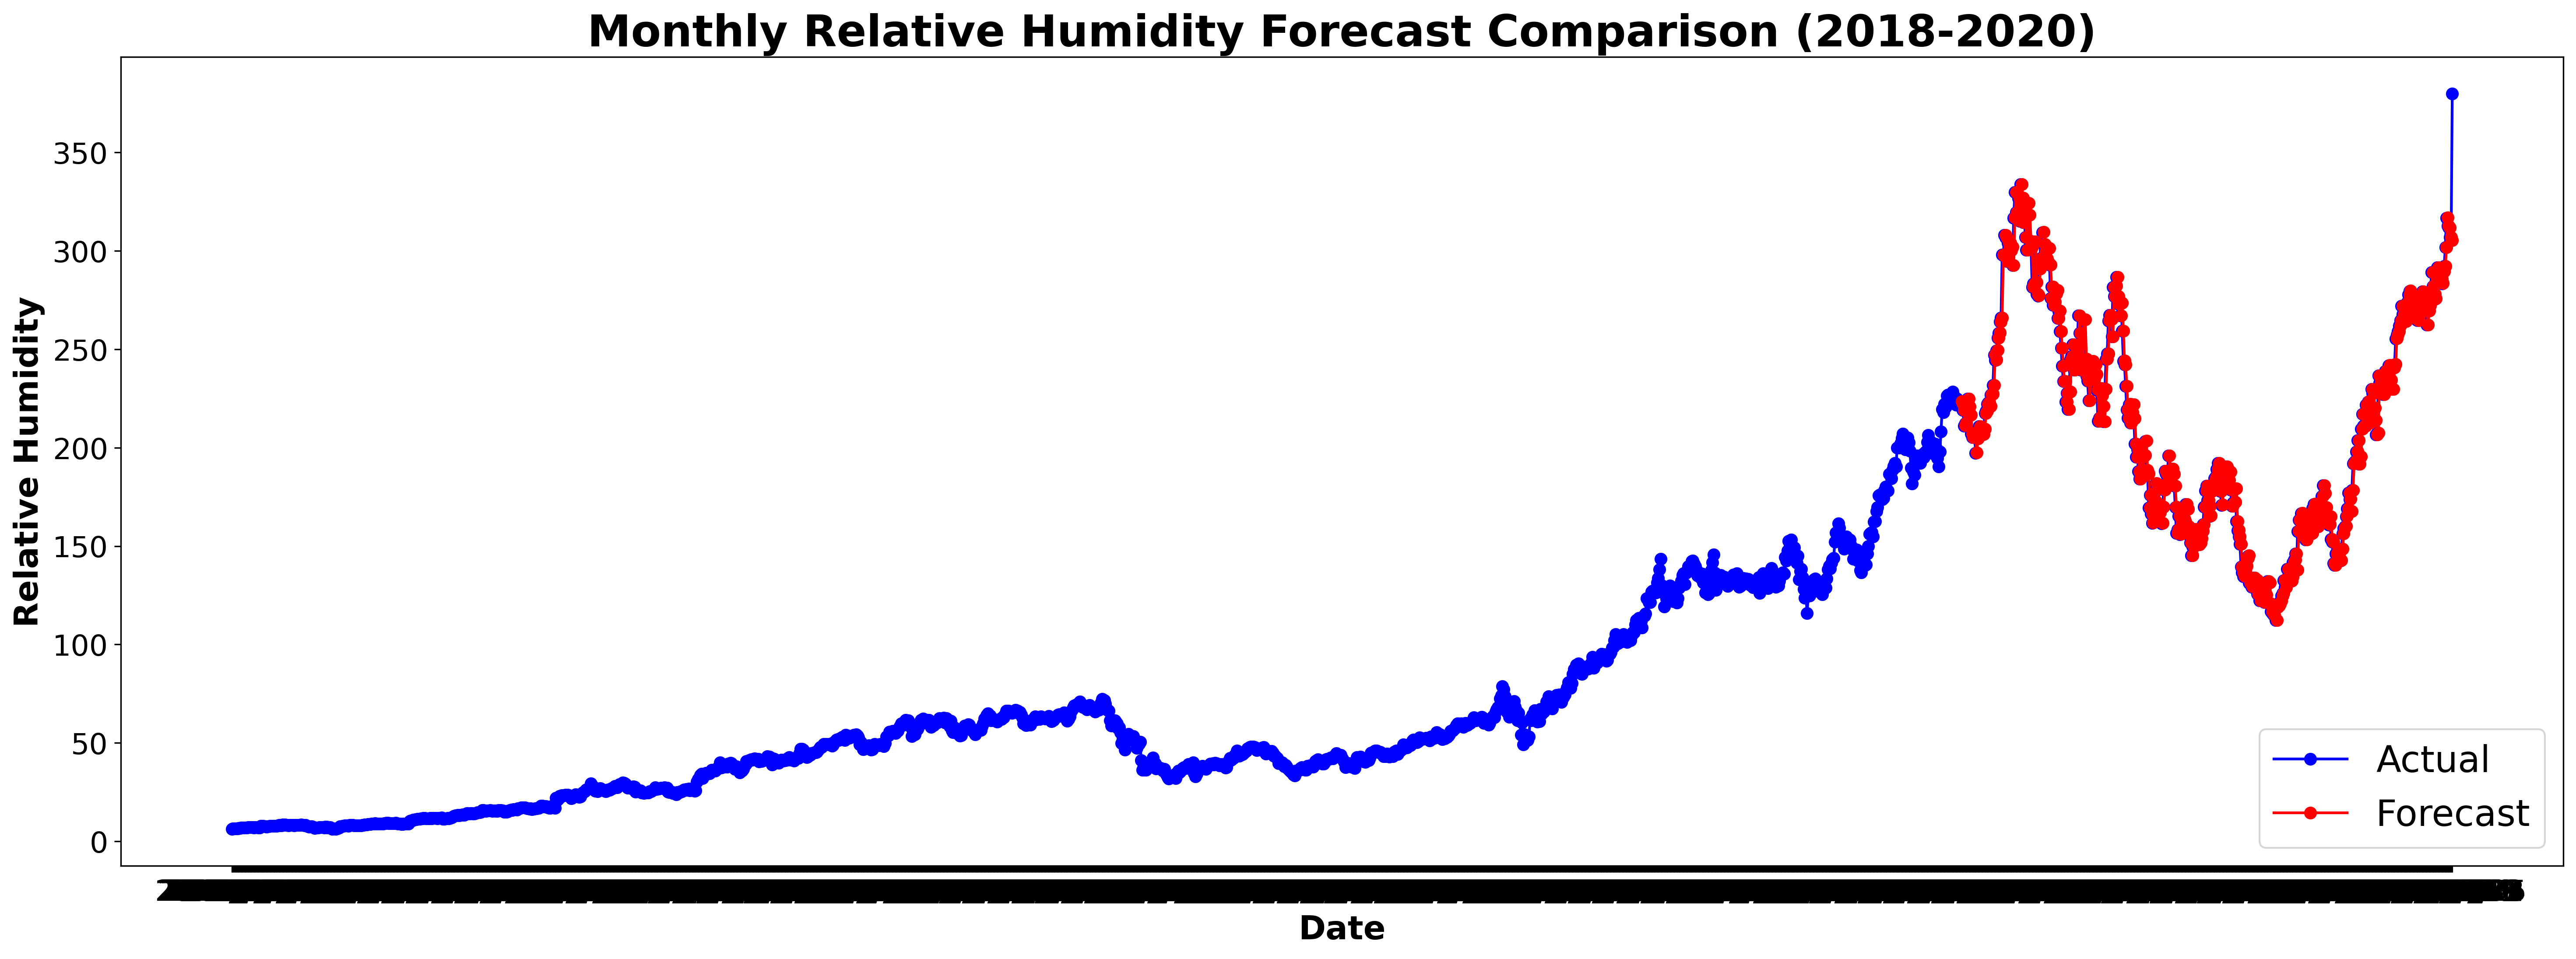

In [94]:
# Plot Y and its corresponding date
# Figure setting
plt.figure(figsize=(24,8),dpi=300)
plt.title('Monthly Relative Humidity Forecast Comparison (2018-2020)',weight='bold',fontsize=24)
plt.xlabel('Date',fontsize=18,weight='bold')
plt.ylabel('Relative Humidity',fontsize=18,weight='bold')

# Comparison of actual value and predicted value according to Date
plt.plot(data.iloc[189:,0],data.iloc[189:,1],marker='o',color='blue',label='Actual')
plt.plot(Results['Date'],Results['Predict'],marker='o',color='red',label='Forecast')


# Set the axis
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Set legends
plt.legend(loc=4,fontsize=20)

plt.show()

# Actual by predicted plot

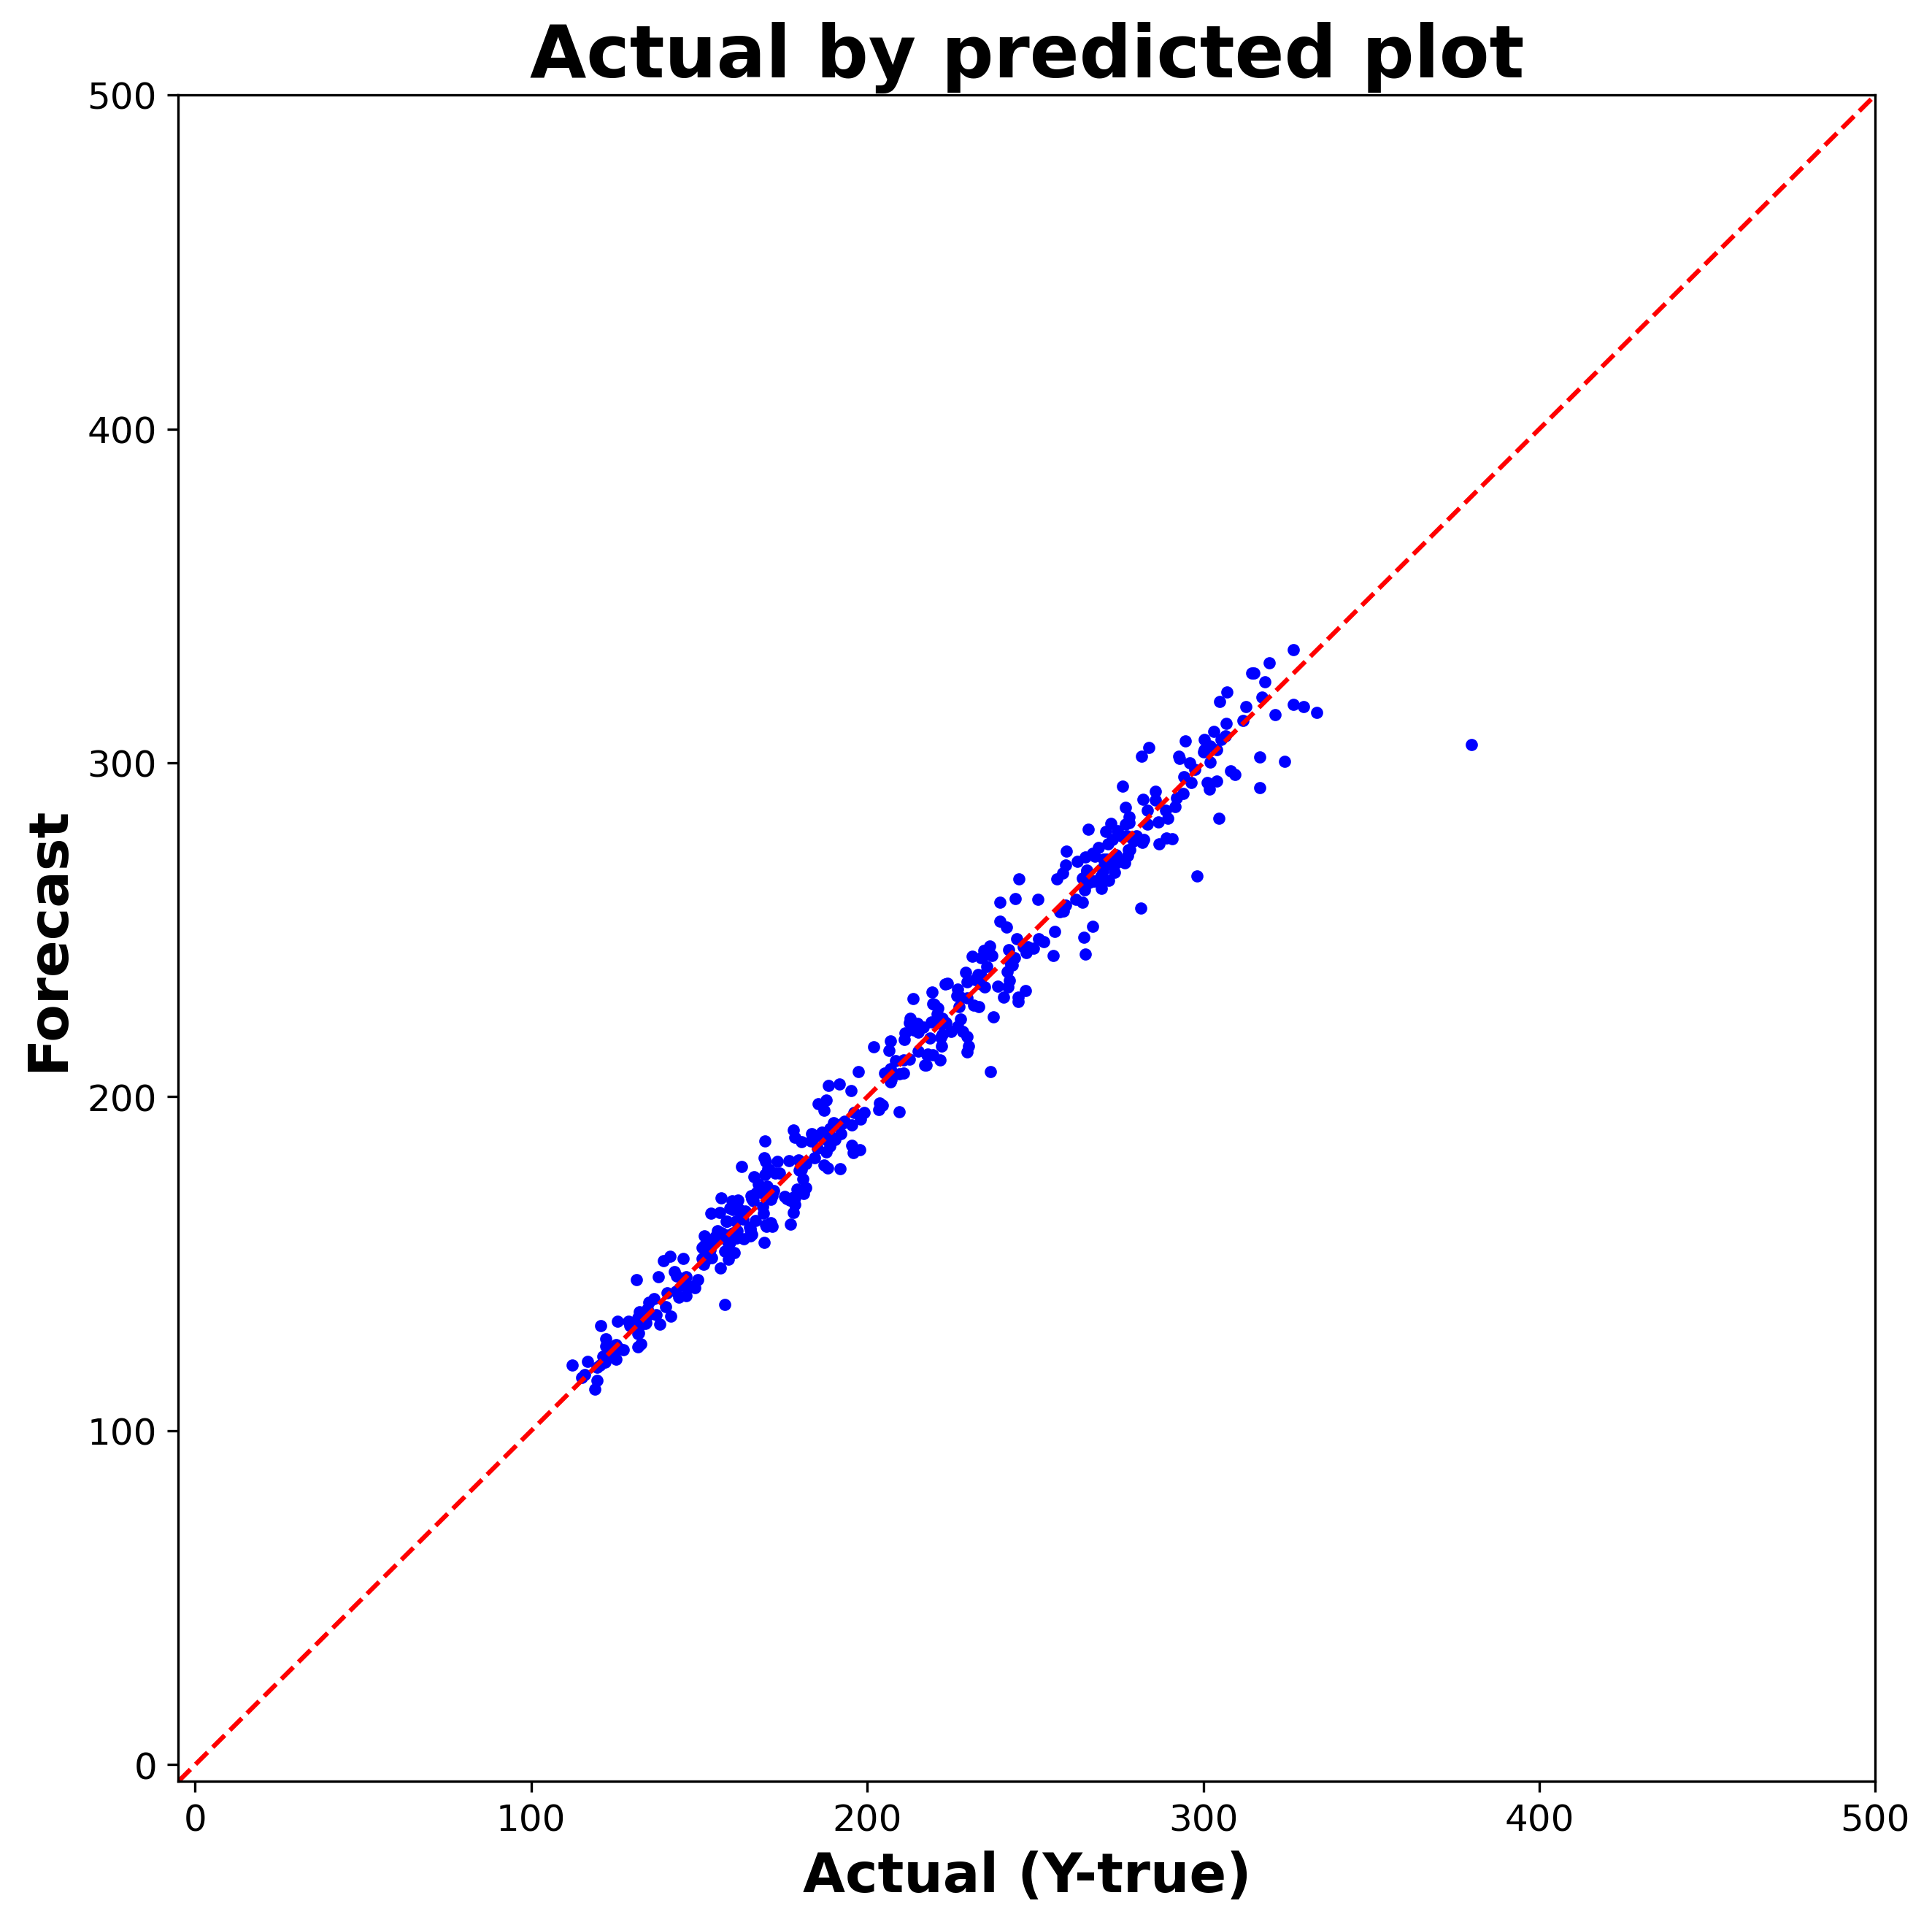

In [95]:
# Lock the scale of axis by Y_true
max_value=500
min_value=0-5

# Figure setting
plt.figure(figsize=(10,10),dpi=300)
plt.title('Actual by predicted plot',weight='bold',fontsize=24)
plt.xlabel('Actual (Y-true)',fontsize=18,weight='bold')
plt.ylabel('Forecast',fontsize=18,weight='bold')

# Perfect model reference line
plt.plot([min_value,max_value], [min_value,max_value], linestyle='--',color='red')

# Actual by predicted plot
plt.scatter(Results.iloc[:,1],Results.iloc[:,2],marker='.',color='blue')

# Set the axis
plt.ylim(0-5,max_value)
plt.xlim(0-5,max_value)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()